<a href="https://colab.research.google.com/github/Rajfekar/PythonML/blob/main/LungCancer_EV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import needed libraries**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**

> Read the training dataset into the dataframe

In [15]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [16]:
# loading the data
data_dir = '/content/lung_colon_image_set/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths  \
0      /content/lung_colon_image_set/lung_image_sets/...   
1      /content/lung_colon_image_set/lung_image_sets/...   
2      /content/lung_colon_image_set/lung_image_sets/...   
3      /content/lung_colon_image_set/lung_image_sets/...   
4      /content/lung_colon_image_set/lung_image_sets/...   
...                                                  ...   
14995  /content/lung_colon_image_set/lung_image_sets/...   
14996  /content/lung_colon_image_set/lung_image_sets/...   
14997  /content/lung_colon_image_set/lung_image_sets/...   
14998  /content/lung_colon_image_set/lung_image_sets/...   
14999  /content/lung_colon_image_set/lung_image_sets/...   

                             labels  
0               Lung_adenocarcinoma  
1               Lung_adenocarcinoma  
2               Lung_adenocarcinoma  
3               Lung_adenocarcinoma  
4               Lung_adenocarcinoma  
...                             ...  
14995  Lung squamous_cell_carcinoma  
14996  Lung squamous_cell_carcinoma  
14997  Lung squamous_cell_carcinoma  
14998  Lung squamous_cell_carcinoma  
14999  Lung squamous_cell_carcinoma  

[15000 rows x 2 columns]

# **Data preprocessing**

first we will check if the training data is balanced or not

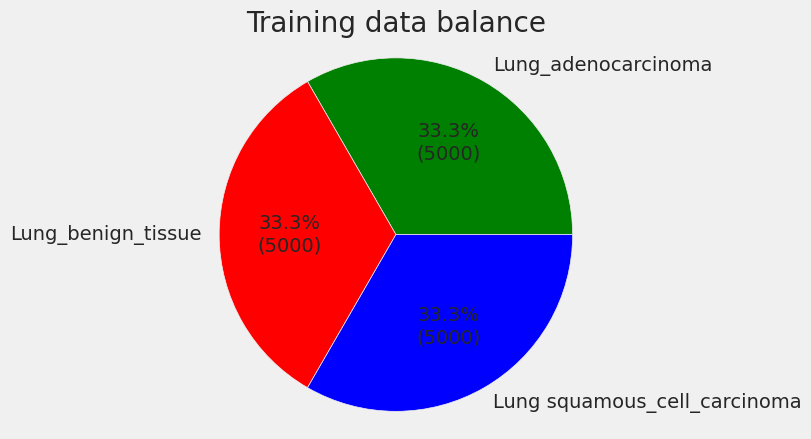

In [59]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["green","red","blue"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

It is balanced, now we will split our data to train, val and test set

In [18]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42) # Train 12000 , 3000

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42) # 1500 , 1500

**Create image data generator**

in this step we will convert the whoole data to numpy arrays

In [19]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


**Display sample from train data**

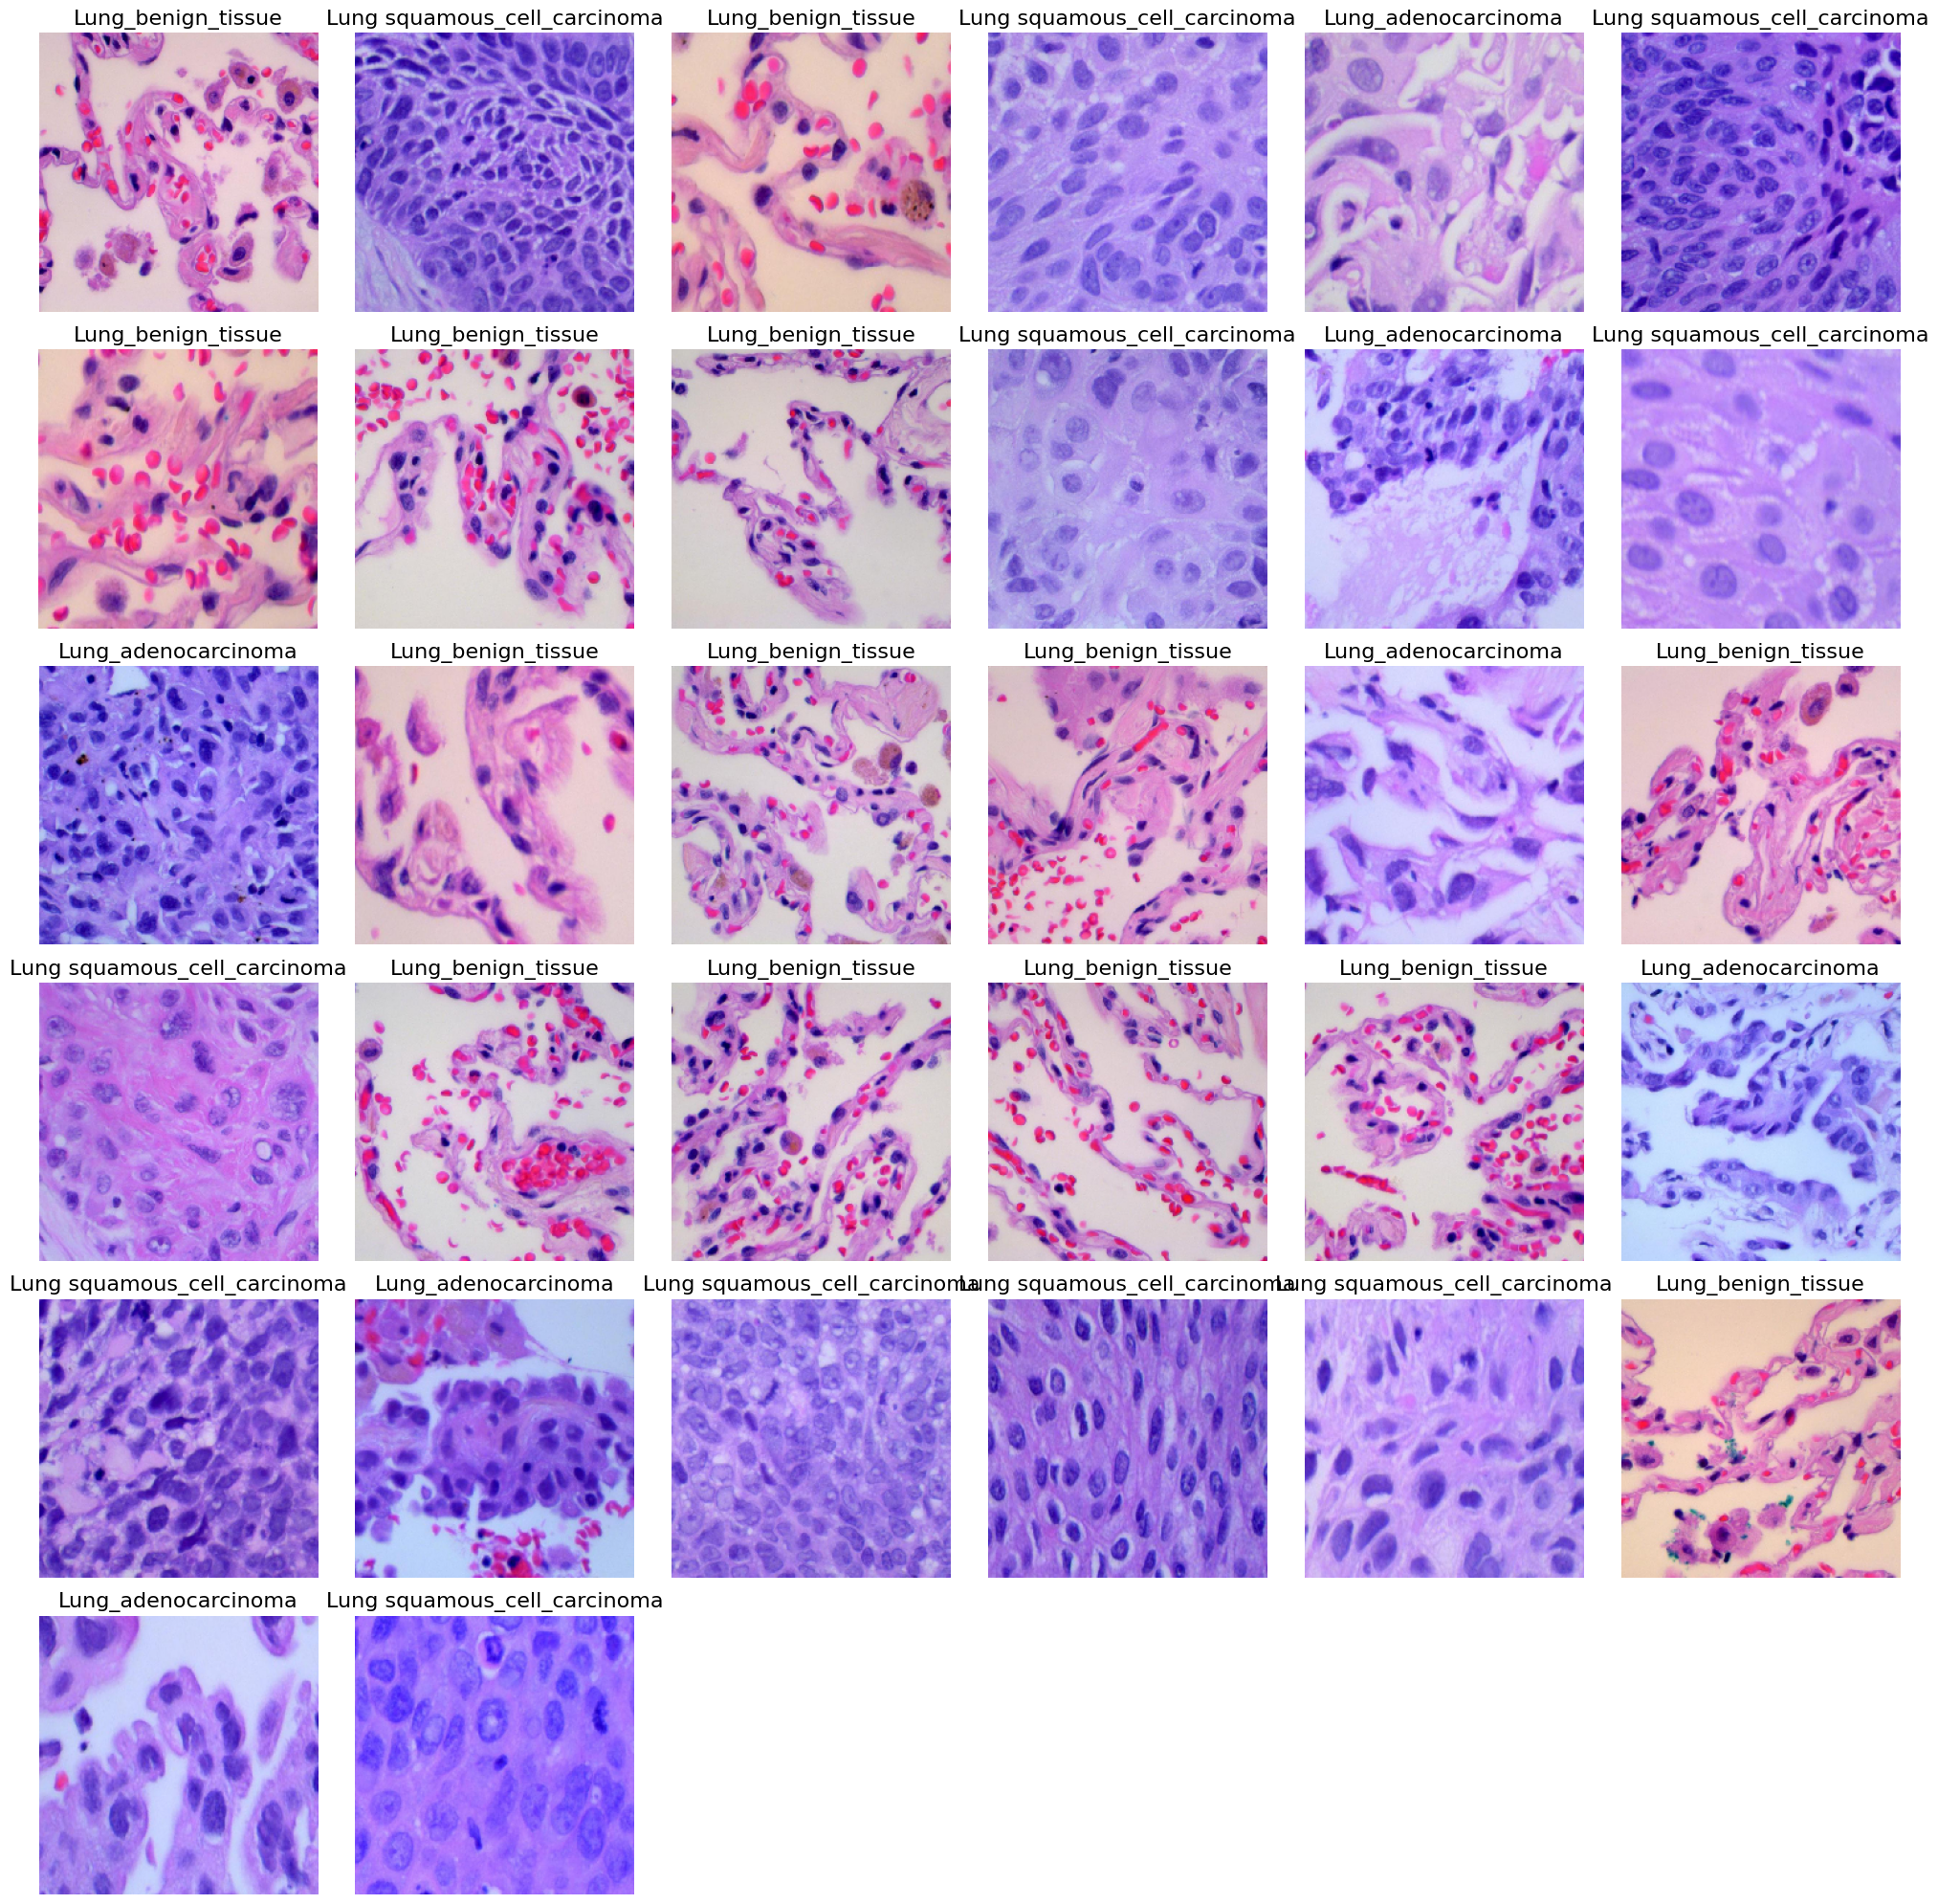

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Create needed functions**

In [20]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


# Defining a convolutional CNN block for a sequential CNN model
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block


# Defining a dense ANN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

# **Model Structure**

# **CNN model**

In [21]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_counts=3
# class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [ ]:
class_counts

3

In [ ]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [ ]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,523 (10.66 MB)

 Trainable params: 2,794,083 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [ ]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2108s 6s/step - accuracy: 0.7881 - loss: 0.5258 - val_accuracy: 0.3180 - val_loss: 3.8861
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2089s 6s/step - accuracy: 0.9119 - loss: 0.2405 - val_accuracy: 0.9033 - val_loss: 0.2208
Epoch 3/20
224/375 ━━━━━━━━━━━━━━━━━━━━ 13:31 5s/step - accuracy: 0.9358 - loss: 0.1741

**Display model performance**

In [ ]:
# Display model performance
model_performance(history, epochs)

**Evaluate the model**

In [ ]:
# Model evaluation
model_evaluation(cnn_model)

**Get predictions and display the confusion matrix**

In [ ]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

# **EfficientNetB3**

In [22]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [23]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [24]:
# train the model
epochs = 10   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 242s 317ms/step - accuracy: 0.6701 - loss: 0.8211 - val_accuracy: 0.3367 - val_loss: 1.9376
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 104s 277ms/step - accuracy: 0.8975 - loss: 0.2895 - val_accuracy: 0.4453 - val_loss: 1.1758
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 104s 278ms/step - accuracy: 0.9349 - loss: 0.1863 - val_accuracy: 0.9567 - val_loss: 0.1133
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - accuracy: 0.9576 - loss: 0.1357 - val_accuracy: 0.9680 - val_loss: 0.1015
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - accuracy: 0.9637 - loss: 0.1172 - val_accuracy: 0.9547 - val_loss: 0.1338
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 104s 278ms/step - accuracy: 0.9741 - loss: 0.0852 - val_accuracy: 0.4140 - val_loss: 1.6118
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 104s 278ms/step - accuracy: 0.9839 - loss: 0.0657 - val_accuracy: 0.9907 - val_loss: 0.0348
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - accuracy: 0.9899 -

**Display model performance**

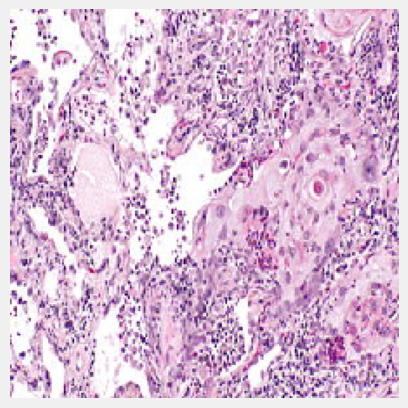

In [50]:

# Load and preprocess the image
# IMAGE_PATH = '/content/lungaca1000.jpeg'
# IMAGE_PATH = '/content/adenocarcinomas-300x200.jpg' class11
IMAGE_PATH = '/content/class2.jpg'

# Load image and resize to 224x224
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))

# Convert to array
img = tf.keras.preprocessing.image.img_to_array(img)

# Normalize the image (optional: EfficientNet expects pixels in [0,1] range)
img = img / 255.0

# Add batch dimension (expected shape: (1, 224, 224, 3))
img = np.expand_dims(img, axis=0)

# View the image
plt.imshow(img[0])
plt.axis("off")  # Hide axis
plt.show()




In [51]:
# Make prediction
predictions = EfficientNetB3_model.predict(img)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[0.7867783  0.20424308 0.00897867]]


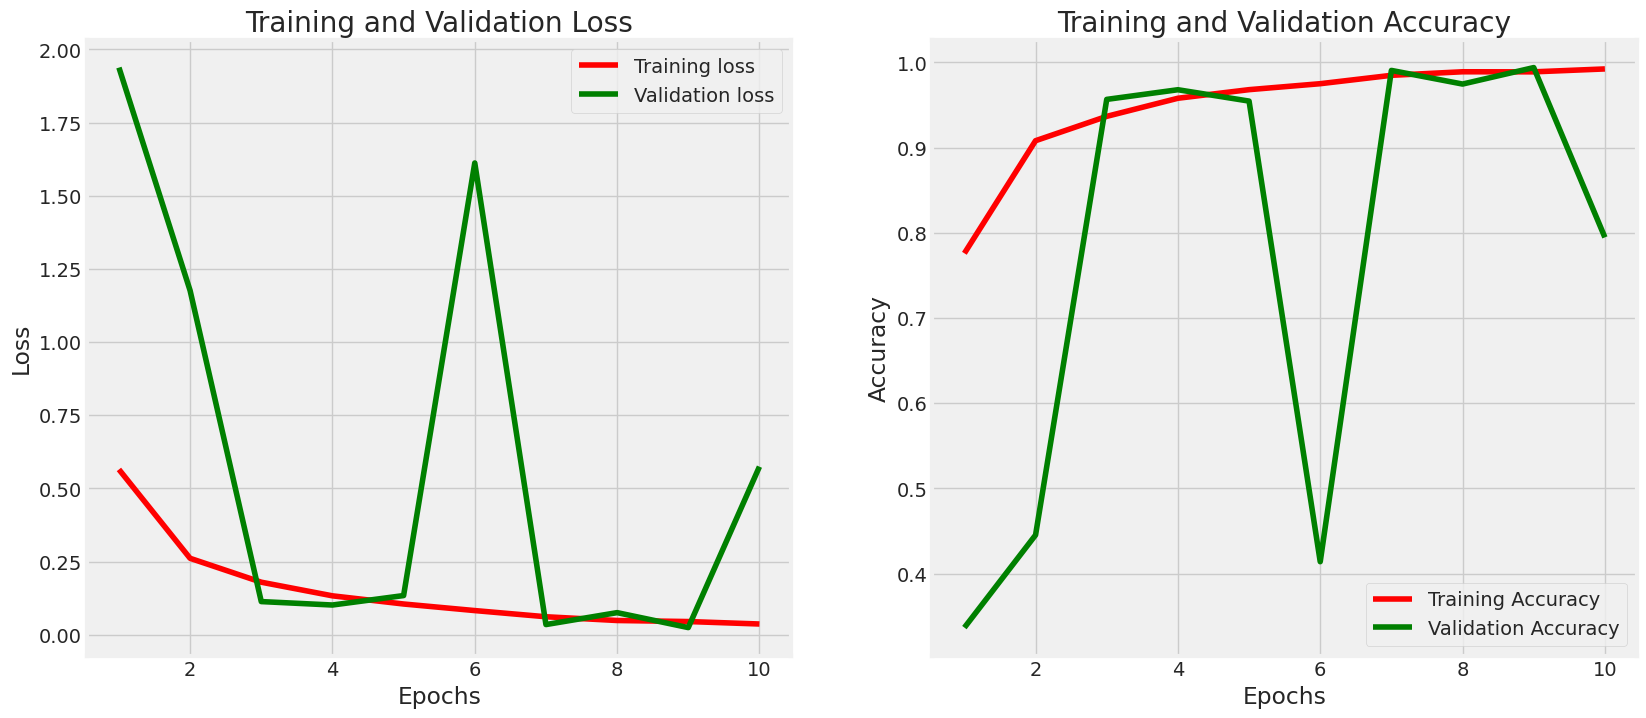

In [45]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

**Evaluate the model**

In [46]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 131ms/step - accuracy: 0.8040 - loss: 0.5308
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.7860 - loss: 0.5936
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7712 - loss: 0.6111
Train Loss:  0.5284924507141113
Train Accuracy:  0.8021666407585144
--------------------
Validation Loss:  0.5742127299308777
Validation Accuracy:  0.7946666479110718
--------------------
Test Loss:  0.580009400844574
Test Accuracy:  0.7873333096504211


**Get predictions and display the confusion matrix**

47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step


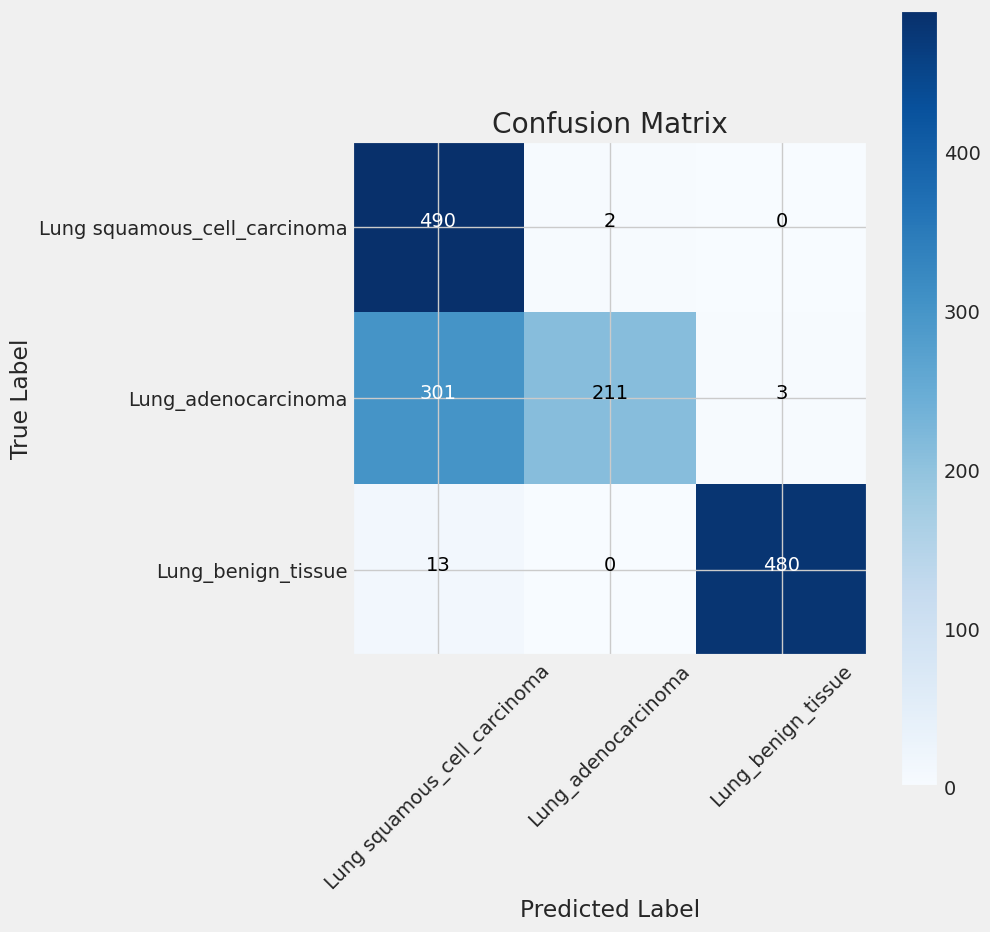

In [47]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)


